In [0]:
# http://pytorch.org/
from os.path import exists
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())
cuda_output = !ldconfig -p|grep cudart.so|sed -e 's/.*\.\([0-9]*\)\.\([0-9]*\)$/cu\1\2/'
accelerator = cuda_output[0] if exists('/dev/nvidia0') else 'cpu'

!pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.4.1-{platform}-linux_x86_64.whl torchvision


import os
import sys
import time
import torch
import requests
import numpy as np
from tqdm import tqdm
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
import torchvision.datasets as datasets



# Constants
IMAGE_WIDTH = 28
IMAGE_HEIGHT = 28
N_CLASSES = 10
BATCH_SIZE = 30
CUDA = torch.cuda.is_available()

TRAIN_FOLDER = r"data/train"
VALID_FOLDER = r"data/validation"
TEST_FOLDER = r"data/test"
RESULT_FOLDER = r"results"


In [0]:
!ls -l data/validation/key/ | egrep -c '^-'

3000


In [0]:
!ls data/test
!ls data/train
!ls data/validation

apple  banana  book  fork  key	ladder	pizza  stop_sign  tennis_racquet  wheel
apple  banana  book  fork  key	ladder	pizza  stop_sign  tennis_racquet  wheel
apple  banana  book  fork  key	ladder	pizza  stop_sign  tennis_racquet  wheel


In [0]:
LEARNING_RATE = 0.00001        #.00001, 0.0001, 0.001, 0.1, 0.01
EPOCHS = 31

class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(IMAGE_WIDTH * IMAGE_HEIGHT, 30)
        self.fc2 = nn.Linear(30, 30)
        #self.fc3 = nn.Linear(500, 500)
        #self.fc4 = nn.Linear(500, 500)
        #self.fc2 = nn.Linear(500, 256)
        self.fc3 = nn.Linear(30, N_CLASSES)
    def forward(self, x):
        x = x.view(-1, IMAGE_WIDTH * IMAGE_HEIGHT)
        x = F.relu(self.fc1(x))
        #x = F.relu(self.fc2(x))
        #x = F.relu(self.fc3(x))
        #x = F.relu(self.fc4(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


def load_sample(x):
	return np.load(x)

def train(epoch, net, train_loader, opt):
    net.train()
    correct = 0.0
    running_training_loss = 0.0
    total = 0.0
    for j, item in enumerate(train_loader, 0):
      inputs, labels = item

      inputs = inputs.view(BATCH_SIZE, 1, IMAGE_WIDTH, IMAGE_HEIGHT).float()
      if CUDA:
          inputs = inputs.cuda()
          labels = labels.cuda()

      # Reset gradients
      opt.zero_grad()

      # Forward pass
      outputs = net(inputs)

      pred = outputs.data.max(1)[1]   # get the index of the max log-probability
      #correct += pred.eq(labels.data).cpu().sum()
      correct += (pred == labels).sum().item()
      total += labels.size()[0]
      #accuracy = 100. * correct / len(train_loader.dataset)
      #accuracy = 100.0 * correct / (bs*200)
      loss = criterion(outputs, labels)
      loss.backward()                 # calculate the gradients (backpropagation)
      optimizer.step()                # update the weights
      running_training_loss += loss.item()
      if j % 200 == 199:
        #print loss and accuracy information every 200 batches
        accuracy = correct / (BATCH_SIZE*200)
        txt = '[%d, %5d] loss: %.3f - training accuracy: %.3f' % (epoch, j + 1, running_training_loss/200, accuracy)
        print(txt)
        running_training_loss = 0.0
        correct = 0.0
        total = 0.0
       

      

def validate(net, val_loader, epoch):
    # set model to validation mode
    net.eval()
    #val_loss, correct, j = 0, 0, 0
    val_correct = 0.0
    running_val_loss = 0.0
    val_total = 0.0
    for inputs, labels in val_loader:

        inputs = inputs.view(BATCH_SIZE, 1, IMAGE_WIDTH, IMAGE_HEIGHT).float()
        if CUDA:
            inputs = inputs.cuda()
            labels = labels.cuda()

        outputs = net(inputs)
        val_loss = criterion(outputs, labels)
        val_pred = outputs.data.max(1)[1]
        #val_correct += pred.eq(labels.data).cpu().sum()
        val_correct += (val_pred == labels).sum().item()
        val_total += labels.size()[0]
        running_val_loss += val_loss.item()
        #if j % 200 == 199:
          #txt = '[%d, %5d] validation: %.3f' % (epoch, j + 1, loss.item())
          #print(txt)
        #j = j + 1

    running_val_loss /= len(val_loader)
    val_accuracy = val_correct / val_total
    print("[]")
    txt = '[ %d ] loss: %.3f - validation accuracy: %.3f' % (epoch, running_val_loss, val_accuracy)
    print(txt)
              
    return running_val_loss, val_accuracy
  
def plot(acc_vector, loss_vector):
    epochs = [i for i in range(1, EPOCHS + 1)]
    plt.plot(epochs, acc_vector)

    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.show()

    plt.plot(epochs, loss_vector)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.show()


    
    
#  --  Start Training    
    
name = "MLP_model1" + "_Adam_" + str(BATCH_SIZE) + "_" + str(LEARNING_RATE).replace(".", "c") + "_" + str(EPOCHS)
#print(name)

train_dataset = datasets.DatasetFolder(TRAIN_FOLDER, extensions = ['.npy'], loader = load_sample)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size = BATCH_SIZE, shuffle = True, num_workers = 0)

test_dataset = datasets.DatasetFolder(TEST_FOLDER, extensions = ['.npy'], loader = load_sample)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size = BATCH_SIZE, shuffle = True, num_workers = 0)

val_dataset = datasets.DatasetFolder(VALID_FOLDER, extensions = ['.npy'], loader = load_sample)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size = BATCH_SIZE, shuffle = True, num_workers = 0)



net = MLP()

  
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr = LEARNING_RATE)
if CUDA:
    net.cuda()

loss_vector = []
acc_vector = []
for ep in range(EPOCHS):  # epochs loop

    #train
    loss_info = train(ep, net, train_loader, optimizer)
    
    #validate
    val_loss, accuracy = validate(net, val_loader, ep)
    

    #loss_vector.append(val_loss)
    #acc_vector.append(accuracy)

    
# Plot train loss and validation accuracy vs epochs for each learning rate
#plot(acc_vector, loss_vector)
    
    

[0,   200] loss: 8.110 - training accuracy: 0.103
[0,   400] loss: 5.359 - training accuracy: 0.129
[0,   600] loss: 3.981 - training accuracy: 0.165
[0,   800] loss: 3.362 - training accuracy: 0.164
[0,  1000] loss: 2.942 - training accuracy: 0.171
[0,  1200] loss: 2.670 - training accuracy: 0.177
[0,  1400] loss: 2.507 - training accuracy: 0.192
[0,  1600] loss: 2.386 - training accuracy: 0.203
[0,  1800] loss: 2.330 - training accuracy: 0.202
[0,  2000] loss: 2.224 - training accuracy: 0.221
[]
[ 0 ] loss: 2.241 - validation accuracy: 0.214
[1,   200] loss: 2.220 - training accuracy: 0.213
[1,   400] loss: 2.166 - training accuracy: 0.236
[1,   600] loss: 2.113 - training accuracy: 0.248
[1,   800] loss: 2.111 - training accuracy: 0.250
[1,  1000] loss: 2.037 - training accuracy: 0.279
[1,  1200] loss: 2.016 - training accuracy: 0.286
[1,  1400] loss: 1.982 - training accuracy: 0.299
[1,  1600] loss: 1.927 - training accuracy: 0.326
[1,  1800] loss: 1.905 - training accuracy: 0.329


In [0]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))
  
  
  
import numpy as np
import matplotlib.pyplot as plt

training_ex = 6e4
training_loss = []
training_accuracy = []
plot_every = 200
filename = "model6.txt"
with open(filename) as f:
	for line in f:
		if("training" in line):
			training_loss.append(float(str(line).split(":")[1][1:]))
      training_accuracy.append(float(str(line).split(":")[2][1:]))
    elif("validation" in line):
      val_loss.append(float(str(line).split(":")[1][1:]))
      val_accuracy.append(float(str(line).split(":")[2][1:]))

      
training_loss = np.asarray(training_loss)
validation_loss = np.asarray(val_loss)
x_axis = np.asarray(range(0,len(training_loss)))
x_axis_val = np.arange(0, len(val_loss))
plt.plot(x_axis*plot_every*BATCH_SIZE / training_ex, training_loss)
plt.plot(x_axis_val, validation_loss)
plt.show()

plt.plot(x_axis*plot_every*BATCH_SIZE / training_ex, training_accuracy)
plt.plot(x_axis_val, validation_loss)
plt.show()

In [0]:
  #Init folder data (NPYs)
  
  urls = [
        'https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/key.npy',
        'https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/banana.npy',
        'https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/ladder.npy',
        'https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/tennis%20racquet.npy',
        'https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/pizza.npy',
        'https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/stop%20sign.npy',
        'https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/wheel.npy',
        'https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/fork.npy',
        'https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/book.npy',
        'https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/apple.npy',
    ]
  
  class_name = ['apple', 'banana', 'book', 'fork', 'key', 'ladder', 'pizza', 'stop_sign', 'tennis_racquet', 'wheel']
   
  def createDir(path):
    if not os.path.exists(path):
        os.makedirs(path)
    
  def gen_bar_updater(pbar):
    def bar_update(count, block_size, total_size):
        if pbar.total is None and total_size:
            pbar.total = total_size
        progress_bytes = count * block_size
        pbar.update(progress_bytes - pbar.n)
    return bar_update   
    
    
  def download_url(url, root, filename):
      from six.moves import urllib
      root = os.path.expanduser(root)
      fpath = os.path.join(root, filename + ".npy")

      createDir(root)

      # downloads file
      if os.path.isfile(fpath):
          a = 1
          #print('Using downloaded and verified file: ' + fpath)
      else:
          try:
              print('Downloading ' + url + ' to ' + fpath)
              urllib.request.urlretrieve(
                  url, fpath,
                  reporthook = gen_bar_updater(tqdm(unit='B', unit_scale=True))
              )
          except OSError:
              if url[:5] == 'https':
                  url = url.replace('https:', 'http:')
                  print('Failed download. Trying https -> http instead.'
                        ' Downloading ' + url + ' to ' + fpath)
                  urllib.request.urlretrieve(
                      url, fpath,
                      reporthook = gen_bar_updater(tqdm(unit='B', unit_scale=True))
                  )
                  
                  
                  
  for i in range(0, len(urls)):
    download_url(urls[i], "data", class_name[i])

  print("----> Download Done!")
    
  step = ['train', 'validation', 'test']

  dire = r'data/'
  createDir(RESULT_FOLDER)

  max_length = 10000 # Maximum number of files (drawings) per class
  percen=[0.6, 0.3, 0.1] # Percentage of training, validation and testing

  begin = [0, int(max_length * percen[0]), int(max_length * (percen[0] + percen[1]))]
  end = [int(max_length * (percen[0])), int(max_length * (percen[0] + percen[1])), max_length-10]

  for c in range(0, len(class_name)):
    print('Class ' + str(c+1) + ' out of ' + str(len(class_name)))
    filename = dire + str(class_name[c]) + '.npy'
    data = np.load(filename)

    for s in range(0, len(step)):
      dire_step = str(dire) + str(step[s])
      if not os.path.exists(dire_step):
        os.makedirs(dire_step)

      for i in range(begin[s], end[s]):
        dire_class = str(dire_step) + '/' + str(class_name[c])
        if not os.path.exists(dire_class):
          os.makedirs(dire_class)

        # Reshape the raw data into 28x28 images
        data_sample = data[i,:].reshape((28, 28))
        sample_name = class_name[c] + '_' + str(step[s]) + '_' + str(i)
        np.save(os.path.join(dire_class, sample_name), data_sample)



0.00B [00:00, ?B/s]



  0%|          | 0.00/126M [00:00<?, ?B/s]

  8%|▊         | 9.63M/126M [00:00<00:01, 96.2MB/s]

 17%|█▋        | 21.2M/126M [00:00<00:01, 101MB/s] 

 27%|██▋       | 33.8M/126M [00:00<00:00, 108MB/s]

 38%|███▊      | 48.1M/126M [00:00<00:00, 116MB/s]

 49%|████▊     | 61.3M/126M [00:00<00:00, 120MB/s]

 59%|█████▉    | 74.7M/126M [00:00<00:00, 124MB/s]

 70%|██████▉   | 87.9M/126M [00:00<00:00, 127MB/s]

 80%|███████▉  | 101M/126M [00:01<00:00, 127MB/s] 

 90%|████████▉ | 113M/126M [00:01<00:00, 125MB/s]

 99%|█████████▉| 125M/126M [00:01<00:00, 123MB/s]

126MB [00:01, 103MB/s]                           

0.00B [00:00, ?B/s]



  0%|          | 0.00/241M [00:00<?, ?B/s]

  3%|▎         | 6.41M/241M [00:00<00:03, 64.1MB/s]

  7%|▋         | 16.9M/241M [00:00<00:03, 72.5MB/s]

 12%|█▏        | 28.7M/241M [00:00<00:02, 81.9MB/s]

 17%|█▋        | 40.5M/241M [00:00<00:02, 90.3MB/s]

 22%|██▏       | 52.7M/241M [00:00<00:01, 97.8MB/s]

 27%|██▋       | 65.3M/241M [00:00<00:01, 105MB/s] 

 32%|███▏      | 78.0M/241M [00:00<00:01, 111MB/s]

 37%|███▋      | 90.1M/241M [00:01<00:01, 114MB/s]

 42%|████▏     | 103M/241M [00:01<00:01, 117MB/s] 

 47%|████▋     | 114M/241M [00:01<00:01, 110MB/s]

 52%|█████▏    | 125M/241M [00:01<00:01, 101MB/s]

 56%|█████▌    | 136M/241M [00:01<00:01, 101MB/s]

 61%|██████▏   | 148M/241M [00:01<00:00, 107MB/s]

 66%|██████▋   | 160M/241M [00:01<00:00, 111MB/s]

 72%|███████▏  | 173M/241M [00:01<00:00, 116MB/s]

 77%|███████▋  | 185M/241M [00:01<00:00, 118MB/s]

 82%|████████▏ | 197M/241M [00:01<00:00, 114MB/s]

 87%|████████▋ | 209M/241M [00:02<00:00, 107MB/s]

 91%|█████████ | 220M



  0%|          | 0.00/98.3M [00:00<?, ?B/s]

  4%|▍         | 4.20M/98.3M [00:00<00:06, 13.9MB/s]

 17%|█▋        | 16.3M/98.3M [00:00<00:04, 18.9MB/s]

 26%|██▌       | 25.2M/98.3M [00:00<00:03, 23.2MB/s]

 38%|███▊      | 37.3M/98.3M [00:00<00:01, 30.6MB/s]

 48%|████▊     | 47.4M/98.3M [00:01<00:01, 38.8MB/s]

 56%|█████▌    | 55.1M/98.3M [00:01<00:01, 41.7MB/s]

 68%|██████▊   | 67.1M/98.3M [00:01<00:00, 47.8MB/s]

 77%|███████▋  | 75.5M/98.3M [00:01<00:00, 51.3MB/s]

 85%|████████▌ | 83.9M/98.3M [00:01<00:00, 57.8MB/s]

 97%|█████████▋| 95.0M/98.3M [00:01<00:00, 67.5MB/s]

98.3MB [00:01, 55.5MB/s]                            

0.00B [00:00, ?B/s]



  0%|          | 0.00/181M [00:00<?, ?B/s]

  3%|▎         | 4.74M/181M [00:00<00:03, 47.4MB/s]

  8%|▊         | 13.8M/181M [00:00<00:03, 55.3MB/s]

 12%|█▏        | 22.0M/181M [00:00<00:02, 61.3MB/s]

 19%|█▊        | 33.8M/181M [00:00<00:02, 71.6MB/s]

 25%|██▍       | 45.1M/181M [00:00<00:01, 80.5MB/s]

 31%|███▏      | 56.8M/181M [00:00<00:01, 88.8MB/s]

 38%|███▊      | 69.5M/181M [00:00<00:01, 97.6MB/s]

 45%|████▌     | 82.4M/181M [00:01<00:00, 105MB/s] 

 52%|█████▏    | 94.9M/181M [00:01<00:00, 111MB/s]

 59%|█████▉    | 108M/181M [00:01<00:00, 115MB/s] 

 66%|██████▌   | 120M/181M [00:01<00:00, 117MB/s]

 73%|███████▎  | 132M/181M [00:01<00:00, 119MB/s]

 80%|███████▉  | 144M/181M [00:01<00:00, 81.2MB/s]

 86%|████████▋ | 157M/181M [00:01<00:00, 90.5MB/s]

 92%|█████████▏| 167M/181M [00:01<00:00, 85.2MB/s]

 99%|█████████▊| 179M/181M [00:02<00:00, 92.2MB/s]

181MB [00:02, 88.0MB/s]                           

0.00B [00:00, ?B/s]



  0%|          | 0.00/102M [00:00<?, ?B/s]

  4%|▍         | 4.20M/102M [00:00<00:03, 27.4MB/s]

 15%|█▍        | 15.3M/102M [00:00<00:02, 35.4MB/s]

 27%|██▋       | 27.6M/102M [00:00<00:01, 45.1MB/s]

 39%|███▉      | 40.1M/102M [00:00<00:01, 55.7MB/s]

 52%|█████▏    | 52.7M/102M [00:00<00:00, 66.9MB/s]

 64%|██████▍   | 65.5M/102M [00:00<00:00, 78.1MB/s]

 77%|███████▋  | 78.2M/102M [00:00<00:00, 88.4MB/s]

 89%|████████▉ | 90.9M/102M [00:01<00:00, 97.1MB/s]

102MB [00:01, 87.0MB/s]                            

0.00B [00:00, ?B/s]



  0%|          | 0.00/93.9M [00:00<?, ?B/s]

  4%|▍         | 4.20M/93.9M [00:00<00:06, 13.5MB/s]

  9%|▉         | 8.40M/93.9M [00:00<00:05, 14.7MB/s]

 21%|██        | 19.7M/93.9M [00:01<00:03, 19.9MB/s]

 33%|███▎      | 30.7M/93.9M [00:01<00:02, 26.4MB/s]

 43%|████▎     | 40.5M/93.9M [00:01<00:01, 33.8MB/s]

 51%|█████     | 47.7M/93.9M [00:01<00:01, 35.9MB/s]

 63%|██████▎   | 59.5M/93.9M [00:01<00:00, 45.4MB/s]

 76%|███████▌  | 71.0M/93.9M [00:01<00:00, 55.5MB/s]

 85%|████████▌ | 80.0M/93.9M [00:01<00:00, 58.3MB/s]

 98%|█████████▊| 92.2M/93.9M [00:01<00:00, 69.1MB/s]


0.00B [00:00, ?B/s]




  0%|          | 0.00/107M [00:00<?, ?B/s]


  5%|▌         | 5.51M/107M [00:00<00:01, 55.0MB/s]


  8%|▊         | 8.40M/107M [00:00<00:04, 22.0MB/s]


 19%|█▉        | 20.5M/107M [00:00<00:02, 29.2MB/s]


 31%|███       | 33.3M/107M [00:00<00:01, 38.0MB/s]


 39%|███▉      | 42.0M/107M [00:01<00:01, 44.5MB/s]


 51%|█████     | 54.4M/107M [00:01<00:00, 55.1MB/s]


 59%|█████▉    | 63.1M/107M [00:01<00:00, 59.9MB/s]


 68%|██████▊   | 73.2M/107M [00:01<00:00, 68.1MB/s]


 78%|███████▊  | 83.9M/107M [00:01<00:00, 76.6MB/s]


 89%|████████▉ | 95.6M/107M [00:01<00:00, 85.4MB/s]


 99%|█████████▊| 106M/107M [00:01<00:00, 86.4MB/s] 


107MB [00:01, 63.2MB/s]                           


0.00B [00:00, ?B/s]




  0%|          | 0.00/98.8M [00:00<?, ?B/s]


 10%|█         | 10.1M/98.8M [00:00<00:00, 101MB/s]


 23%|██▎       | 22.4M/98.8M [00:00<00:00, 106MB/s]


 35%|███▌      | 35.0M/98.8M [00:00<00:00, 112MB/s]


 48%|████▊     | 47.2M/98.8M [00:00<00:00, 115MB/s]


 60%|█████▉    | 58.8M/98.8M [00:00<00:00, 115MB/s]


 71%|███████   | 70.4M/98.8M [00:00<00:00, 115MB/s]


 82%|████████▏ | 80.8M/98.8M [00:00<00:00, 105MB/s]


 92%|█████████▏| 91.3M/98.8M [00:01<00:00, 105MB/s]


98.8MB [00:01, 90.3MB/s]                           


0.00B [00:00, ?B/s]




  0%|          | 0.00/93.6M [00:00<?, ?B/s]


  8%|▊         | 7.32M/93.6M [00:00<00:01, 73.2MB/s]


 20%|█▉        | 18.6M/93.6M [00:00<00:00, 81.7MB/s]


 32%|███▏      | 29.7M/93.6M [00:00<00:00, 88.9MB/s]


 43%|████▎     | 40.6M/93.6M [00:00<00:00, 94.0MB/s]


 57%|█████▋    | 52.9M/93.6M [00:00<00:00, 101MB/s] 


 70%|██████▉   | 65.2M/93.6M [00:00<00:00, 107MB/s]


 83%|████████▎ | 77.4M/93.6M [00:00<00:00, 111MB/s]


 95%|█████████▌| 89.3M/93.6M [00:01<00:00, 113MB/s]


93.6MB [00:01, 83.6MB/s]                           


0.00B [00:00, ?B/s]




  0%|          | 0.00/113M [00:00<?, ?B/s]


  6%|▌         | 6.95M/113M [00:00<00:01, 69.4MB/s]


 13%|█▎        | 14.3M/113M [00:00<00:01, 70.5MB/s]


 20%|██        | 23.2M/113M [00:00<00:01, 75.3MB/s]


 29%|██▉       | 33.0M/113M [00:00<00:00, 80.8MB/s]


 40%|███▉      | 45.0M/113M [00:00<00:00, 89.7MB/s]


 50%|█████     | 57.0M/113M [00:00<00:00, 96.9MB/s]


 61%|██████    | 69.3M/113M [00:00<00:00, 104MB/s] 


 72%|███████▏  | 81.6M/113M [00:01<00:00, 109MB/s]


 83%|████████▎ | 93.9M/113M [00:01<00:00, 113MB/s]


 94%|█████████▎| 106M/113M [00:01<00:00, 116MB/s] 


113MB [00:01, 88.8MB/s]                          

----> Download Done!
Class 1 out of 10
Class 2 out of 10
Class 3 out of 10
Class 4 out of 10




93.9MB [00:20, 69.1MB/s]                            

Class 5 out of 10
Class 6 out of 10
Class 7 out of 10
Class 8 out of 10
Class 9 out of 10
Class 10 out of 10


In [0]:
rm -rf data/

In [0]:
a = { "a": "onw", "fs": "ovn"}
print(a)

{'a': 'onw', 'fs': 'ovn'}


# TEST

In [0]:
running_test_loss=0.0
test_total=0.0
test_correct=0.0
  
for i, test_data in enumerate(test_loader,0): 
  test_inputs, test_labels = test_data
  test_inputs = test_inputs.view(BATCH_SIZE, 1, 28, 28).float()
  test_inputs = test_inputs.cuda()
  test_labels = test_labels.cuda()
  test_outputs = net(test_inputs)
  test_loss = criterion(test_outputs, test_labels)
  running_test_loss += test_loss.item()
  
  _,predicted=torch.max(test_outputs.data,1)
  test_total=test_total+test_labels.size(0)
  test_correct=test_correct + (predicted == test_labels).sum().item()        
  
test_accuracy=test_correct/test_total
  
print('Test Loss: %.3f - Test Accuracy: %.3f' %
         (running_test_loss/len(test_loader), test_accuracy))

Test Loss: 0.762 - Test Accuracy: 0.751


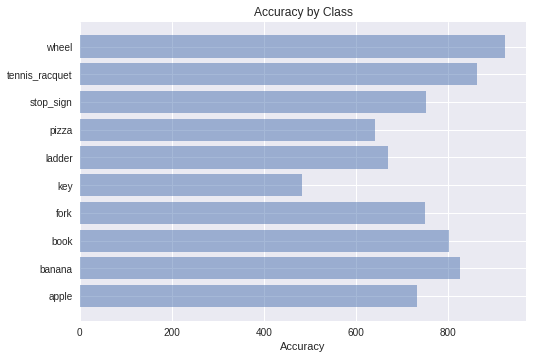

In [0]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in test_loader:
        test_inputs, test_labels = data
        test_inputs = test_inputs.view(BATCH_SIZE, 1, 28, 28).float()
        test_inputs = test_inputs.cuda()
        test_labels = test_labels.cuda()
        test_outputs = net(test_inputs)
        _, predicted = torch.max(test_outputs.data,1)
        c = (predicted == test_labels).squeeze()
        for i in range(BATCH_SIZE):
            label = test_labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1

x=np.arange(len(class_name))
plt.barh(x, class_correct, align='center', alpha=0.5)
plt.yticks(x, class_name)
plt.xlabel('Accuracy')
plt.title('Accuracy by Class')
 
plt.show()